<a href="https://colab.research.google.com/github/NARAEIM/tp2-da/blob/jennlee/jenn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

# List the contents of your Google Drive
drive_path = '/content/drive/MyDrive/co_note/project/data'
files = os.listdir(drive_path)
print(files)

['transaction_new.csv', 'click_stream_new.csv', 'customer.csv', 'product.csv']


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.style.use("default")

In [4]:
# Load the datasets
transaction = pd.read_csv('/content/drive/MyDrive/co_note/project/data/transaction_new.csv')
customer = pd.read_csv('/content/drive/MyDrive/co_note/project/data/customer.csv')
product = pd.read_csv('/content/drive/MyDrive/co_note/project/data/product.csv')
click_stream = pd.read_csv('/content/drive/MyDrive/co_note/project/data/click_stream_new.csv')

# Dataset

# New Section

## Transaction

In [ ]:
transaction.isna().sum()

created_at                     0
customer_id                    0
booking_id                     0
session_id                     0
payment_method                 0
payment_status                 0
promo_amount                   0
promo_code                773446
shipment_fee                   0
shipment_date_limit            0
shipment_location_lat          0
shipment_location_long         0
total_amount                   0
product_id                     0
quantity                       0
item_price                     0
dtype: int64

In [5]:
transaction['created_at'] = pd.to_datetime(transaction['created_at']).dt.strftime('%Y-%m-%d')
transaction['shipment_date_limit'] = pd.to_datetime(transaction['shipment_date_limit']).dt.strftime('%Y-%m-%d')
transaction['created_at'] = pd.to_datetime(transaction['created_at'])
transaction['shipment_date_limit'] = pd.to_datetime(transaction['shipment_date_limit'])

In [6]:
transaction[['created_at','shipment_date_limit']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254585 entries, 0 to 1254584
Data columns (total 2 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   created_at           1254585 non-null  datetime64[ns]
 1   shipment_date_limit  1254585 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 19.1 MB


In [12]:
transaction['month'] = transaction['created_at'].dt.month
transaction['year'] = transaction['created_at'].dt.year

In [7]:
# promocode labeling (1: w/ promo, 0: w/o promo)
transaction['w_promo'] = transaction['promo_code'].fillna(0).map(lambda x: 1 if x != 0 else 0).astype(int)
transaction['w_promo']

0          1
1          0
2          0
3          0
4          0
          ..
1254580    0
1254581    1
1254582    1
1254583    1
1254584    1
Name: w_promo, Length: 1254585, dtype: int64

In [17]:
transaction = transaction[transaction['payment_status']=='Success']

In [13]:
# import random

groups = transaction.groupby('booking_id')

# Filter the groups with 5 occurrences and w_promo == 1
filtered_groups = groups.filter(lambda x: len(x) == 5 and (x['w_promo'] == 1).all())

# random row from the filtered groups
print(filtered_groups.sample(n=1))

       created_at  customer_id                            booking_id  \
283623 2019-06-01         7441  326a43ad-ea57-4cfb-823e-042748377f25   

                                  session_id payment_method payment_status  \
283623  28f2495b-c2ea-4140-8c33-efe0a0801e60          Gopay        Success   

        promo_amount     promo_code  shipment_fee shipment_date_limit  \
283623          9051  WEEKENDMANTAP             0          2019-06-04   

        shipment_location_lat  shipment_location_long  total_amount  \
283623                0.46627              123.615232       1798446   

        product_id  quantity  item_price  w_promo  month  year  
283623       36783         1      210042        1      6  2019  


In [ ]:
display(transaction.head(), transaction.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254585 entries, 0 to 1254584
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   created_at              1254585 non-null  datetime64[ns]
 1   customer_id             1254585 non-null  int64         
 2   booking_id              1254585 non-null  object        
 3   session_id              1254585 non-null  object        
 4   payment_method          1254585 non-null  object        
 5   payment_status          1254585 non-null  object        
 6   promo_amount            1254585 non-null  int64         
 7   promo_code              1254585 non-null  object        
 8   shipment_fee            1254585 non-null  int64         
 9   shipment_date_limit     1254585 non-null  datetime64[ns]
 10  shipment_location_lat   1254585 non-null  float64       
 11  shipment_location_long  1254585 non-null  float64       
 12  total_amount  

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,w_promo
0,2018-07-29,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03,-8.227893,111.969107,199832,54728,1,191247,1
1,2018-07-30,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,0,10000,2018-08-03,3.013470,107.802514,155526,16193,1,145526,0
2,2018-09-15,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,0,10000,2018-09-18,-2.579428,115.743885,550696,53686,4,135174,0
3,2018-11-01,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,0,0,2018-11-05,-3.602334,120.363824,271012,20228,1,271012,0
4,2018-12-18,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,0,0,2018-12-23,-3.602334,120.363824,198753,55220,1,198753,0


None

In [14]:
t = transaction[transaction['booking_id']=='ac78f1d8-88ed-4b7f-8279-37a3150cb243']

In [15]:
transaction.columns

Index(['created_at', 'customer_id', 'booking_id', 'session_id',
       'payment_method', 'payment_status', 'promo_amount', 'promo_code',
       'shipment_fee', 'shipment_date_limit', 'shipment_location_lat',
       'shipment_location_long', 'total_amount', 'product_id', 'quantity',
       'item_price', 'w_promo', 'month', 'year'],
      dtype='object')

In [16]:
t = t[['created_at', 'customer_id', 'booking_id','promo_amount', 'promo_code','w_promo',
       'total_amount','month', 'year']]
t

,created_at,customer_id,booking_id,promo_amount,promo_code,w_promo,total_amount,month,year
1074827,2022-04-23,49893,ac78f1d8-88ed-4b7f-8279-37a3150cb243,2739,WEEKENDMANTAP,1,931670,4,2022
1074828,2022-04-23,49893,ac78f1d8-88ed-4b7f-8279-37a3150cb243,2739,WEEKENDMANTAP,1,931670,4,2022
1074829,2022-04-23,49893,ac78f1d8-88ed-4b7f-8279-37a3150cb243,2739,WEEKENDMANTAP,1,931670,4,2022
1074830,2022-04-23,49893,ac78f1d8-88ed-4b7f-8279-37a3150cb243,2739,WEEKENDMANTAP,1,931670,4,2022
1074831,2022-04-23,49893,ac78f1d8-88ed-4b7f-8279-37a3150cb243,2739,WEEKENDMANTAP,1,931670,4,2022


In [21]:
transaction[transaction.product_id == 53598]

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,w_promo
100235,2022-05-10,14508,5ad52679-b675-4597-85cb-205a1838b852,10b9cc47-5b94-417c-bcb1-d2ce240ef9b1,Debit Card,Success,0,NaN,10000,2022-05-13,-7.738869,111.866067,1766208,53598,4,439052,0
105373,2020-11-16,97646,bb01ceab-c7da-4489-af0b-66a4a1f015ac,4f91176f-d4da-445c-9798-aa85c277ca1f,Credit Card,Success,0,NaN,10000,2020-11-17,-6.174661,106.777310,141772,53598,1,131772,0
112731,2019-11-30,82971,1c326064-53b7-4863-bcda-f5fe8328f24a,93dab5b0-4243-4a4d-847c-e3c85b80deb0,OVO,Success,3696,WEEKENDSERU,0,2019-12-06,-3.559862,115.392499,189822,53598,1,193518,1
128543,2021-10-18,69565,dcfc44cf-a4bb-420f-a08f-5df23b627002,9e431eba-106a-45fd-a885-cc74f5adf358,OVO,Success,0,NaN,0,2021-10-20,-0.765064,114.021358,467777,53598,1,289360,0
144481,2021-09-08,13831,08035dcf-7d85-42b6-b8e6-fa500a7b6019,c225512f-8a21-42fa-86f0-f7bcd4b7cf5c,Credit Card,Success,0,NaN,10000,2021-09-09,-7.136894,109.154973,1046680,53598,1,114994,0
182981,2021-07-30,32999,be7a0bfc-0bd1-430e-bf6c-160e5d0a4ee9,363ded58-a79b-4cd8-a61a-b3adde490a50,Gopay,Success,0,NaN,50000,2021-08-03,-8.042712,112.176352,1196132,53598,1,249337,0
253709,2021-01-22,31491,f64865aa-f802-479f-abdf-14f4d5c35651,420c7edd-51e2-4adc-8863-2268ebb7a2ab,Credit Card,Success,0,NaN,10000,2021-01-28,-4.793074,104.514306,196001,53598,1,186001,0
300423,2020-02-23,59520,4bc9ab6a-2930-42ef-9026-b99a11917d20,17e72519-c20f-407d-872e-be04403fcdc0,Debit Card,Success,0,NaN,0,2020-02-28,-7.011278,109.322374,526805,53598,1,242887,0
316819,2022-06-05,12563,352a6038-2e77-4ef7-88ea-7b734898d2ab,88f46b8c-f736-4a9c-8c31-94142ceb51ea,LinkAja,Success,0,NaN,0,2022-06-06,-6.153161,106.921454,296088,53598,1,296088,0
333141,2022-04-21,66041,6afb316f-0588-4389-87bf-0f5f8d81b6ad,9390a312-6604-49d7-ae19-2458f6b4d59b,LinkAja,Success,0,NaN,10000,2022-04-23,-6.126763,106.918337,961357,53598,1,310076,0


In [ ]:
transaction['payment_status'].unique()

array(['Success'], dtype=object)

In [27]:
# promo in July
transactions_july = transaction[transaction['month'] == 7]
promo_sales_july = transactions_july.groupby('promo_code')['total_amount'].sum()

# promo in 2021
transactions_2021 = transaction[transaction['year'] == 2021]
promo_sales_2021 = transactions_2021.groupby('promo_code')['total_amount'].sum()

print('Sales w/ Promo in July:', promo_sales_july.sort_values())
print('\nSales w/ Promo in 2021:', promo_sales_2021.sort_values())

Sales w/ Promo in July: promo_code
STARTUP           1719078719
SC2022            1726827295
WEEKENDMANTAP     3283554683
LIBURDONG         3689966826
XX2022            7116266521
BUYMORE           8872672885
WEEKENDSERU       9518087742
AZ2022           13390321547
Name: total_amount, dtype: int64

Sales w/ Promo in 2021: promo_code
SC2022            6144718398
STARTUP           6389686940
WEEKENDMANTAP     9004517973
LIBURDONG         9708038443
XX2022           19880948672
WEEKENDSERU      27815502219
BUYMORE          31674707435
AZ2022           41848207527
Name: total_amount, dtype: int64


In [ ]:
# promo_code 별 transaction 발생 수
grouped = transaction.groupby('promo_code').size().sort_values(ascending=False)
grouped

promo_code
0                773446
AZ2022           131312
BUYMORE           98373
WEEKENDSERU       91489
XX2022            65802
LIBURDONG         31084
WEEKENDMANTAP     30013
SC2022            16649
STARTUP           16417
dtype: int64

In [ ]:
# promo_code 별 transaction이 일어난 total_amount
grouped_amt = transaction.groupby('promo_code')['total_amount'].sum().sort_values(ascending=False)
grouped_amt

promo_code
0                918598633336
AZ2022           155586781463
BUYMORE          116497387627
WEEKENDSERU      106414186422
XX2022            74687436338
LIBURDONG         36395488250
WEEKENDMANTAP     34318974756
STARTUP           20214991605
SC2022            19670838781
Name: total_amount, dtype: int64

In [31]:
# count of transaction when payment was successful
scs_trans = transaction[(transaction['promo_code'] != 0) & (transaction['payment_status'] == 'Success')].groupby('promo_code').size()
print('Count of Transaction by promo_code \n', scs_trans)

Count of Transaction by promo_code 
 promo_code
AZ2022           125748
BUYMORE           94204
LIBURDONG         29708
SC2022            15956
STARTUP           15744
WEEKENDMANTAP     28788
WEEKENDSERU       87677
XX2022            63146
dtype: int64


In [32]:
# sum of transaction when payment was successful
promo_sum = transaction[(transaction['promo_code'] != 0) & (transaction['payment_status'] == 'Success')].groupby('promo_code')['total_amount'].sum().sort_values(ascending=False)
print('Sum of Transaction by promo_code \n',promo_sum)

Sum of Transaction by promo_code 
 promo_code
AZ2022           149099541743
BUYMORE          110947884438
WEEKENDSERU      102421110557
XX2022            72320031960
LIBURDONG         34802390026
WEEKENDMANTAP     33204811592
STARTUP           19616470219
SC2022            18977337505
Name: total_amount, dtype: int64


In [ ]:
transaction.shape[0]

1254585

In [ ]:
p_failure = transaction[transaction['payment_status'] == 'Failed'].shape[0]
print("failed transaction: ", p_failure)
print("successful transaction:", transaction[transaction['payment_status'] == 'Success'].shape[0])

failed transaction:  53550
successful transaction: 1201035


In [ ]:
deducted_count = grouped - scs_trans
deducted_count

promo_code
0                   NaN
AZ2022           5564.0
BUYMORE          4169.0
LIBURDONG        1376.0
SC2022            693.0
STARTUP           673.0
WEEKENDMANTAP    1225.0
WEEKENDSERU      3812.0
XX2022           2656.0
dtype: float64

Proportion of transactions with promotions: 0.38
Proportion of transactions without promotions: 0.62


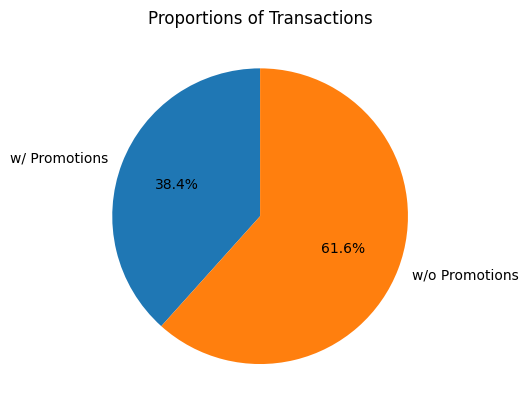

In [ ]:
# Calculate the proportion of transactions with promotions
total_transactions = len(transaction)
promotions_count = (transaction['promo_code'] == 1).sum()
promotions_proportion = promotions_count / total_transactions

# Calculate the proportion of transactions without promotions
no_promotions_count = (transaction['promo_code'] == 0).sum()
no_promotions_proportion = no_promotions_count / total_transactions

print("Proportion of transactions with promotions:", promotions_proportion.round(2))
print("Proportion of transactions without promotions:", no_promotions_proportion.round(2))

# Calculate the proportions
proportions = [promotions_proportion, no_promotions_proportion]
labels = ['w/ Promotions', 'w/o Promotions']

plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proportions of Transactions')

# Display the chart
plt.show()

promo_avg_amount: 1171773.82
non_promo_avg_amount: 1187670.03


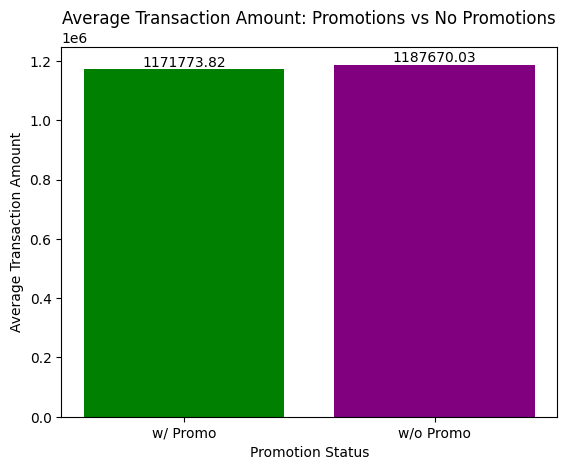

In [ ]:
# Filter transactions with promotions
promo_trx = transaction[transaction['promo_code']==1]

# Filter transactions without promotions
non_promo_trx = transaction[transaction['promo_code']==0]

# average transaction amount for transactions w/ promo
promo_avg_amount = promo_trx['total_amount'].mean()

# average transaction amount for transactions w/o promo
non_promo_avg_amount = non_promo_trx['total_amount'].mean()

print("promo_avg_amount:", promo_avg_amount.round(2))
print("non_promo_avg_amount:", non_promo_avg_amount.round(2))

# Create a bar plot to compare the average transaction amounts
labels = ['w/ Promo', 'w/o Promo']
amounts = [promo_avg_amount, non_promo_avg_amount]
colors = ['green', 'purple']

plt.bar(labels, amounts, color=colors)

# Add value labels on top of each bar
for i, v in enumerate(amounts):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom', fontsize=10)

plt.xlabel('Promotion Status')
plt.ylabel('Average Transaction Amount')
plt.title('Average Transaction Amount: Promotions vs No Promotions')
plt.show()

## Customer

In [ ]:
display(customer.head(),customer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   first_name          100000 non-null  object 
 2   last_name           100000 non-null  object 
 3   username            100000 non-null  object 
 4   email               100000 non-null  object 
 5   gender              100000 non-null  object 
 6   birthdate           100000 non-null  object 
 7   device_type         100000 non-null  object 
 8   device_id           100000 non-null  object 
 9   device_version      100000 non-null  object 
 10  home_location_lat   100000 non-null  float64
 11  home_location_long  100000 non-null  float64
 12  home_location       100000 non-null  object 
 13  home_country        100000 non-null  object 
 14  first_join_date     100000 non-null  object 
dtypes: float64(2), int64(1), object(12)

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


None

In [ ]:
customer[customer['home_country']!= 'Indonesia']

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date


In [41]:
# changing datatype (object -> datetime)
customer['birthdate'] = pd.to_datetime(customer['birthdate'])
customer['first_join_date'] = pd.to_datetime(customer['first_join_date'])

In [9]:
customer[['first_join_date','birthdate']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   first_join_date  100000 non-null  datetime64[ns]
 1   birthdate        100000 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 1.5 MB


In [10]:
customer['year_month'] = customer['first_join_date'].dt.to_period('M')  # Extract the year and month as a period

influx_by_month_year = customer.groupby('year_month').size().sort_values(ascending = False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(influx_by_month_year)

year_month
2021-07    3348
2020-07    2500
2022-01    2361
2021-10    2247
2021-08    2214
2022-07    2202
2019-07    2100
2022-05    2054
2022-04    2019
2018-07    2016
2022-03    1954
2021-09    1934
2021-11    1919
2022-02    1919
2021-12    1877
2020-08    1859
2022-06    1851
2021-01    1775
2017-07    1725
2021-05    1707
2020-10    1589
2020-11    1569
2021-03    1501
2021-06    1439
2020-05    1430
2020-09    1426
2020-12    1415
2021-04    1413
2019-08    1402
2021-02    1386
2020-02    1340
2019-11    1302
2019-12    1278
2019-03    1264
2019-09    1258
2019-06    1243
2018-09    1238
2019-10    1232
2020-04    1190
2018-12    1186
2020-03    1183
2020-06    1175
2020-01    1145
2018-08    1138
2019-02    1111
2017-12    1104
2019-05    1089
2018-06    1079
2018-03    1061
2018-11    1048
2017-10    1039
2017-09    1022
2018-10    1021
2019-04    1015
2019-01    1009
2018-01     994
2017-08     960
2018-04     957
2017-11     931
2018-05     925
2018-02     924
2016-10     8

July has the most active customer influx

In [11]:
customer['year'] = customer['first_join_date'].dt.year  # Extract the year
customer['month'] = customer['first_join_date'].dt.month  # Extract the month

influx_by_year = customer.groupby('year').size()
influx_by_month = customer.groupby('month').size()

# Print the customer influx by year and month
print("Customer Influx by Year:")
print(influx_by_year)

print("\nCustomer Influx by Month:")
print(influx_by_month)

Customer Influx by Year:
year
2016     4729
2017    11440
2018    13587
2019    15303
2020    17821
2021    22760
2022    14360
dtype: int64

Customer Influx by Month:
month
1      8100
2      7429
3      7773
4      7457
5      7915
6      7504
7     14716
8      8293
9      7629
10     8009
11     7533
12     7642
dtype: int64


- 2021 has the most active customer influx, accounting for 22.7%.
- July has the most active customer influx, accounting for 14.7%.


 > check promo's impact on influx in transaction dataset.<br/>
 -> promo most used in July<br/>
 -> promo mostly used in 2021

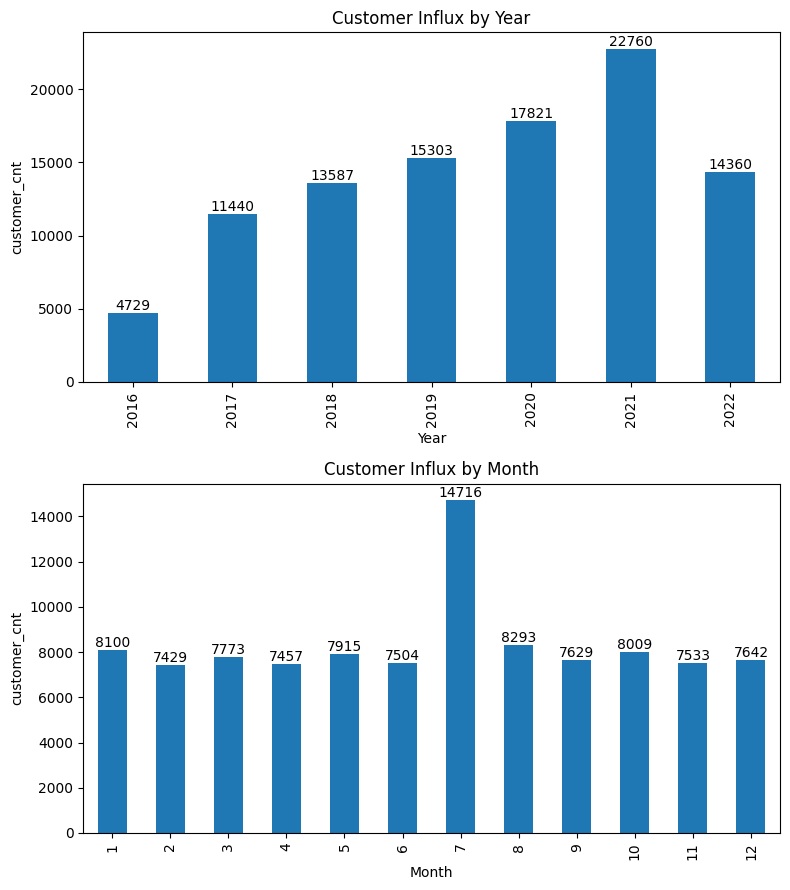

In [13]:
# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 9))

# customer influx by year
influx_by_year.plot(kind='bar', ax=ax1)
ax1.set_title('Customer Influx by Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('customer_cnt')
# Add numbers on top of each bar
for i, v in enumerate(influx_by_year):
    ax1.annotate(str(v), xy=(i, v), ha='center', va='bottom')

# customer influx by month
influx_by_month.plot(kind='bar', ax=ax2)
ax2.set_title('Customer Influx by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('customer_cnt')
# Add numbers on top of each bar
for i, v in enumerate(influx_by_month):
    ax2.annotate(str(v), xy=(i, v), ha='center', va='bottom')

plt.tight_layout()

# Display the graph
plt.show()

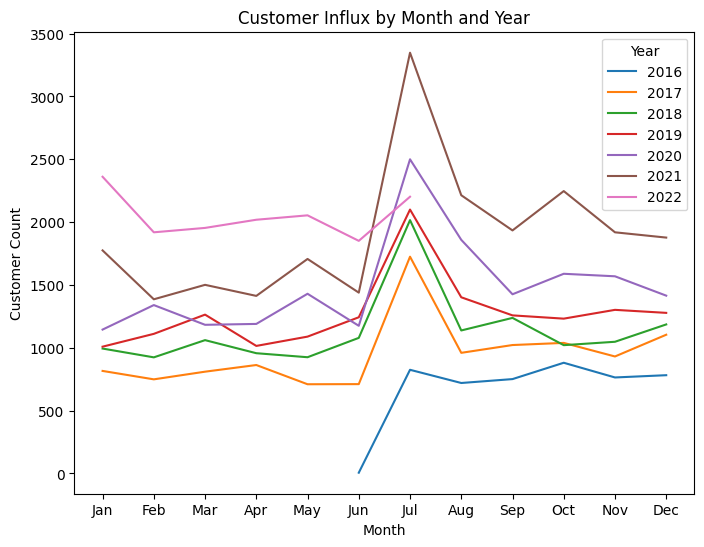

In [16]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Group customer influx by year and month
influx_by_year_month = customer.groupby(['year', 'month']).size().unstack()

# Plot each year as a separate line
for year in influx_by_year_month.index:
    ax.plot(range(1, 13), influx_by_year_month.loc[year], label=str(year))

# Set the x-axis and y-axis labels
ax.set_xlabel('Month')
ax.set_ylabel('Customer Count')

# Set the title
ax.set_title('Customer Influx by Month and Year')

# Set the x-axis ticks and labels
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add a legend
ax.legend(title='Year')

# Display the graph
plt.show()

In [ ]:
customer.isna().sum()

customer_id           0
first_name            0
last_name             0
username              0
email                 0
gender                0
birthdate             0
device_type           0
device_id             0
device_version        0
home_location_lat     0
home_location_long    0
home_location         0
home_country          0
first_join_date       0
dtype: int64

In [ ]:
# drop the unnecessary columns 
columns_to_drop = ['email', 'home_location_lat', 'home_location_long', 'first_name', 'last_name', 'home_country']
customer.drop(columns=columns_to_drop, inplace=True)
customer

## Product

In [ ]:
display(product.info(),product.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44446 non-null  int64  
 1   gender              44446 non-null  object 
 2   masterCategory      44446 non-null  object 
 3   subCategory         44446 non-null  object 
 4   articleType         44446 non-null  object 
 5   baseColour          44431 non-null  object 
 6   season              44425 non-null  object 
 7   year                44445 non-null  float64
 8   usage               44129 non-null  object 
 9   productDisplayName  44439 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


None

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
product.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

In [51]:
product[product.id==57622]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
7350,57622,Men,Personal Care,Skin Care,Sunscreen,White,Spring,2017.0,NaN,Lotus Herbals Safe Sun Sunscreen for Men


In [18]:
product[product.masterCategory=='Free Items']

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
352,53598,Men,Free Items,Free Gifts,Free Gifts,Black,Winter,2016.0,Sports,Q&Q Men Black Digital Watch
826,49696,Men,Free Items,Free Gifts,Ties,Blue,Summer,2012.0,Formal,Park Avenue Blue Patterned Tie
874,53591,Men,Free Items,Free Gifts,Free Gifts,White,Winter,2016.0,Casual,Q&Q Men White Dial Watch
1137,45894,Men,Free Items,Free Gifts,Free Gifts,Black,Winter,2016.0,Casual,Maxima Men Black Dial Watch
1360,53596,Men,Free Items,Free Gifts,Free Gifts,Navy Blue,Winter,2016.0,Casual,Q&Q Men Navy Blue Digital Watch
1376,52676,Women,Free Items,Free Gifts,Free Gifts,White,Winter,2016.0,Casual,Morellato Women White Dial Watch
1394,29975,Women,Free Items,Free Gifts,Free Gifts,Black,Winter,2016.0,Casual,Aspen Women Black Dial Watch
1551,29981,Women,Free Items,Free Gifts,Free Gifts,Blue,Winter,2016.0,Casual,Aspen Women Blue Dial Watch
2543,51091,Women,Free Items,Free Gifts,Free Gifts,Green,Summer,2012.0,Ethnic,Satya Paul Green Saree
2663,54970,Women,Free Items,Free Gifts,Free Gifts,Pink,Spring,2017.0,Casual,Rasasi Women Body Lotion


In [ ]:
product['season'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
44441    False
44442    False
44443    False
44444    False
44445    False
Name: season, Length: 44446, dtype: bool

In [ ]:
product.usage.unique()

array(['Casual', 'Ethnic', 'Formal', 'Sports', nan, 'Smart Casual',
       'Travel', 'Party', 'Home'], dtype=object)

In [ ]:
print(product[product['year'].isna()])

          id gender masterCategory subCategory articleType baseColour season  \
21285  53781    Men        Apparel     Topwear     Tshirts       Blue    NaN   

       year   usage                      productDisplayName  
21285   NaN  Sports  Puma Men Blue Sless Round Neck T-shirt  


In [ ]:
# year (float -> int)
# Fill NaN value in 'year' column with a specific integer value (e.g., -1)
product['year'] = product['year'].fillna(-1).astype(int)

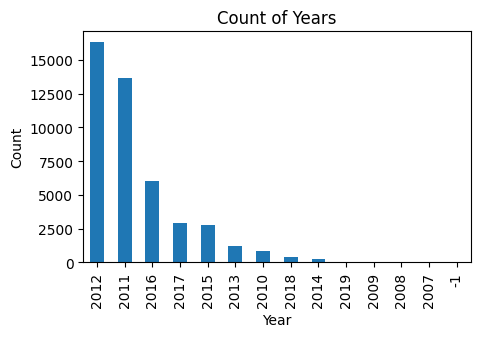

In [ ]:
year_counts = product['year'].value_counts()

plt.figure(figsize=(5, 3))
year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Years')
plt.show()

In [ ]:
product['year'].value_counts()

 2012    16290
 2011    13689
 2016     6007
 2017     2917
 2015     2780
 2013     1213
 2010      846
 2018      405
 2014      236
 2019       33
 2009       20
 2008        7
 2007        2
-1           1
Name: year, dtype: int64

회사의 설립이 16년에 됐기 때문에 제품 연도를 제품의 생산년도로 파악하기로 했다.

## click_stream

In [ ]:
display(click_stream.head(10), click_stream.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833602 entries, 0 to 12833601
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   session_id       object 
 1   event_name       object 
 2   event_time       object 
 3   event_id         object 
 4   traffic_source   object 
 5   product_id       float64
 6   quantity         float64
 7   item_price       float64
 8   payment_status   object 
 9   search_keywords  object 
 10  promo_code       object 
 11  promo_amount     float64
dtypes: float64(4), object(8)
memory usage: 1.1+ GB


,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,NaN,NaN,NaN,NaN
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN
5,7d440441-e67a-4d36-b324-80ffd636d166,SEARCH,2019-09-01T12:07:00.322763Z,c952142b-4fe9-4694-ad7f-21a5d1bed9ca,MOBILE,NaN,NaN,NaN,NaN,Dress Kondangan,NaN,NaN
6,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:08:27.322763Z,365b3840-9647-4bf5-917f-f0bec3d05332,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7d440441-e67a-4d36-b324-80ffd636d166,ITEM_DETAIL,2019-09-01T12:09:49.322763Z,1a1e3548-108e-4520-bf04-1b01d43a72cb,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,7d440441-e67a-4d36-b324-80ffd636d166,SCROLL,2019-09-01T12:11:06.322763Z,f7246095-b094-46c1-b2ac-bcfd080146c3,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,7d440441-e67a-4d36-b324-80ffd636d166,ITEM_DETAIL,2019-09-01T12:12:19.322763Z,74a000dc-b931-4c59-abcc-02e991623bc1,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


None

In [ ]:
click_stream.event_name.unique()

array(['HOMEPAGE', 'SCROLL', 'ADD_TO_CART', 'BOOKING', 'SEARCH',
       'ITEM_DETAIL', 'ADD_PROMO', 'CLICK', 'PROMO_PAGE'], dtype=object)

In [ ]:
click_stream.payment_status.value_counts()

Success    815962
Failed      36620
Name: payment_status, dtype: int64

In [ ]:
click_stream.shape

(12833602, 12)

In [ ]:
import math
click_stream.shape[0] - click_stream['promo_code'].isna().sum()

326535

In [ ]:
click_stream.isna().sum()

session_id                0
event_name                0
event_time                0
event_id                  0
traffic_source            0
product_id         10896445
quantity           10896445
item_price         10896445
payment_status     11981020
search_keywords    11660336
promo_code         12507067
promo_amount       12507067
dtype: int64

# EDA

In [42]:
# Merge transaction and customer datasets
merged = pd.merge(transaction, customer, on='customer_id', how='left')
merged.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,...,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2018-07-29,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03,...,F,2000-08-20,Android,d1b5c84a-7718-4b7b-b5a2-cfa23d7dd836,Android 8.0.0,-6.122897,106.876500,Jakarta Raya,Indonesia,2018-07-28
1,2018-07-30,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03,...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28
2,2018-09-15,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18,...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28
3,2018-11-01,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05,...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28
4,2018-12-18,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23,...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28


In [19]:
merged.columns

Index(['created_at', 'customer_id', 'booking_id', 'session_id',
       'payment_method', 'payment_status', 'promo_amount', 'promo_code',
       'shipment_fee', 'shipment_date_limit', 'shipment_location_lat',
       'shipment_location_long', 'total_amount', 'product_id', 'quantity',
       'item_price', 'w_promo', 'month', 'year', 'first_name', 'last_name',
       'username', 'email', 'gender', 'birthdate', 'device_type', 'device_id',
       'device_version', 'home_location_lat', 'home_location_long',
       'home_location', 'home_country', 'first_join_date'],
      dtype='object')

In [43]:
merged = merged[['first_join_date', 'customer_id', 'created_at',
       'payment_method', 'payment_status', 'w_promo','promo_amount','promo_code','device_type',
       'quantity', 'item_price', 'total_amount', 'product_id', 'gender', 'birthdate']]

## promo_code 사용된 device

In [44]:
merged_new = merged[['first_join_date', 'customer_id', 'created_at','w_promo',
                     'promo_amount', 'promo_code','product_id', 'gender', 'birthdate', 'device_type']]

In [45]:
merged_new['device_type'].unique()

array(['Android', 'iOS'], dtype=object)

In [46]:
# promo_code 별 
pivot_device = pd.pivot_table(merged_new, index='promo_code', columns='device_type', aggfunc='size', fill_value=0)

# sum by device type
pivot_device.loc['Total'] = pivot_device.sum()

# Print the pivot table
print(pivot_device)

device_type    Android     iOS
promo_code                    
AZ2022           96820   28928
BUYMORE          72684   21520
LIBURDONG        22736    6972
SC2022           12265    3691
STARTUP          12253    3491
WEEKENDMANTAP    21891    6897
WEEKENDSERU      67545   20132
XX2022           48753   14393
Total           354947  106024


In [62]:
merged_new['promo_code'].unique()

array(['WEEKENDSERU', nan, 'WEEKENDMANTAP', 'AZ2022', 'LIBURDONG',
       'BUYMORE', 'XX2022', 'STARTUP', 'SC2022'], dtype=object)

In [68]:
promo_data = merged_new[merged_new['promo_code'] == 'SC2022']

# transaction 이 일어난 요일 추출
promo_data['weekday'] = promo_data['created_at'].dt.weekday

promo_data['weekday'].unique()

<ipython-input-68-f42d0514abda>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promo_data['weekday'] = promo_data['created_at'].dt.weekday


array([4, 2, 3, 1, 0])

In [ ]:
# weekend promo: 'WEEKENDSERU', 'WEEKENDMANTAP','LIBURDONG', 'STARTUP'
# weekdays promo: 'XX2022', 'AZ2022', 'BUYMORE', 'SC2022'

In [72]:
promo_data = merged_new[merged_new['promo_code'] == 'AZ2022']

# transaction 이 일어난 연도 추출
promo_data['year'] = promo_data['created_at'].dt.year
promo_data['year'].unique()

<ipython-input-72-3beaeb14cdcd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promo_data['year'] = promo_data['created_at'].dt.year


array([2019, 2020, 2021, 2022, 2018, 2017, 2016])

## promo 사용한 고객 연령층

- 간단하게, 현재 시점 기준으로 나이 측정하자

In [32]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201035 entries, 0 to 1201034
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   first_join_date  1201035 non-null  object        
 1   customer_id      1201035 non-null  int64         
 2   created_at       1201035 non-null  datetime64[ns]
 3   payment_method   1201035 non-null  object        
 4   payment_status   1201035 non-null  object        
 5   w_promo          1201035 non-null  int64         
 6   promo_amount     1201035 non-null  int64         
 7   promo_code       460971 non-null   object        
 8   device_type      1201035 non-null  object        
 9   quantity         1201035 non-null  int64         
 10  item_price       1201035 non-null  int64         
 11  total_amount     1201035 non-null  int64         
 12  product_id       1201035 non-null  int64         
 13  gender           1201035 non-null  object        
 14  bi

In [47]:
# 현재나이 (2022년 기준)
merged['birthdate'] = pd.to_datetime(merged['birthdate'])
merged['birth_year'] = merged['birthdate'].dt.year
merged['age_now'] = 2022 - merged['birth_year'].astype(int)

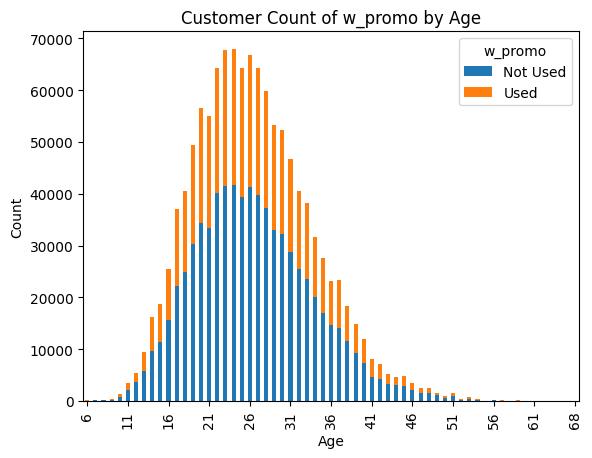

In [48]:
# w_promo
# data by age and count the occurrences of w_promo
promo_counts_by_age = merged.groupby('age_now')['w_promo'].value_counts().unstack().fillna(0)

# Create the plot
promo_counts_by_age.plot(kind='bar', stacked=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Customer Count of w_promo by Age')
plt.legend(title='w_promo', labels=['Not Used', 'Used'])

# Set the x-axis tick labels to show every 5th age
plt.xticks(range(0, len(promo_counts_by_age.index), 5), promo_counts_by_age.index[::5])

# Display the plot
plt.show()

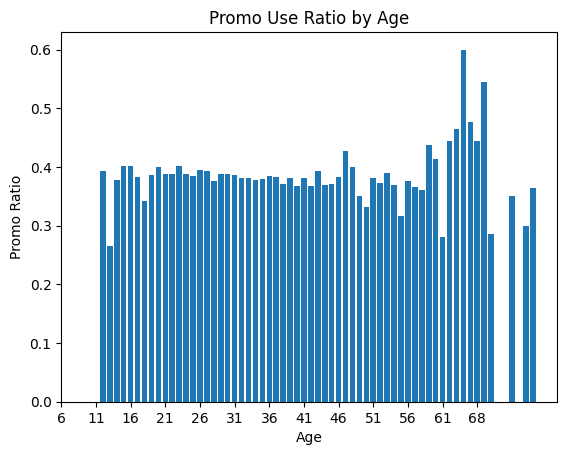

In [37]:
# Calculate the ratio of promo used out of the total count
promo_ratio_by_age = promo_counts_by_age[1] / (promo_counts_by_age[0] + promo_counts_by_age[1])

# Create the plot
plt.bar(promo_ratio_by_age.index, promo_ratio_by_age)
plt.xlabel('Age')
plt.ylabel('Promo Ratio')
plt.title('Promo Use Ratio by Age')

# Set the x-axis tick labels to show every 5th age
plt.xticks(range(0, len(promo_ratio_by_age.index), 5), promo_ratio_by_age.index[::5])

# Display the plot
plt.show()

## total sales for new customer vs existing customer by year

In [ ]:
# join_year 추출
merged_new['join_year'] = merged_new['first_join_date'].dt.year
merged_new['created_year'] = merged_new['created_at'].dt.year

# year index 생성
sales_by_year = pd.DataFrame(index=merged_new['join_year'].sort_values().unique())

# 2016
# s_16 = merged_new[merged_new['join_year'] == 2016]
s_16_new = merged_new[(merged_new['join_year'] == 2016) & (merged_new['created_year'] == 2016)]['total_amount'].sum()
s_16_existing = 0

#2017
s_17_new = merged_new[(merged_new['join_year'] == 2017) & (merged_new['created_year'] == 2017)]['total_amount'].sum()
s_17_existing = merged_new[(merged_new['created_year'] == 2017) & (merged_new['join_year'] < 2017)]['total_amount'].sum()
# -> 이때 transaction['created_at'].dt.year 도 2017이어야함

# 2018
s_18_new = merged_new[(merged_new['join_year'] == 2018) & (merged_new['created_year'] == 2018)]['total_amount'].sum()
s_18_existing = merged_new[(merged_new['created_year'] == 2018) & (merged_new['join_year'] < 2018)]['total_amount'].sum()

# 2019
s_19_new = merged_new[(merged_new['join_year'] == 2019) & (merged_new['created_year'] == 2019)]['total_amount'].sum()
s_19_existing = merged_new[(merged_new['created_year'] == 2019) & (merged_new['join_year'] < 2019)]['total_amount'].sum()

# 2020
s_20_new = merged_new[(merged_new['join_year'] == 2020) & (merged_new['created_year'] == 2020)]['total_amount'].sum()
s_20_existing = merged_new[(merged_new['created_year'] == 2020) & (merged_new['join_year'] < 2020) & (merged_new['join_year'] == 2019)]['total_amount'].sum()

# 2021
s_21_new = merged_new[(merged_new['join_year'] == 2021) & (merged_new['created_year'] == 2021)]['total_amount'].sum()
s_21_existing = merged_new[(merged_new['created_year'] == 2021) & (merged_new['join_year'] < 2021)]['total_amount'].sum()

# 2022
s_22_new = merged_new[(merged_new['join_year'] == 2022) & (merged_new['created_year'] == 2022)]['total_amount'].sum()
s_22_existing = merged_new[(merged_new['created_year'] == 2021) & (merged_new['join_year'] < 2022)]['total_amount'].sum()

# Create a dictionary to store the data
data = {
    'Year': [2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'New Customers': [s_16_new, s_17_new, s_18_new, s_19_new, s_20_new, s_21_new, s_22_new],
    'Existing Customers': [s_16_existing, s_17_existing, s_18_existing, s_19_existing, s_20_existing, s_21_existing, s_22_existing]
}

# Create a DataFrame from the data
sales_by_year = pd.DataFrame(data)

# Set the 'Year' column as the index
sales_by_year.set_index('Year', inplace=True)
sales_by_year

,New Customers,Existing Customers
Year,,
2016,8172407708,0
2017,35637685826,20121654839
2018,43577186422,80091287655
2019,43185849550,147411198411
2020,63551655541,77497803488
2021,95709427644,333674551165
2022,61849222404,429383978809


In [ ]:
# total sales by summing 'New Customers' and 'Existing Customers'
sales_by_year['Total'] = sales_by_year[['New Customers', 'Existing Customers']].sum(axis=1)
sales_by_year

,New Customers,Existing Customers,Total
Year,,,
2016,8172407708,0,8172407708
2017,35637685826,20121654839,55759340665
2018,43577186422,80091287655,123668474077
2019,43185849550,147411198411,190597047961
2020,63551655541,77497803488,141049459029
2021,95709427644,333674551165,429383978809
2022,61849222404,429383978809,491233201213


2020년도 existing customers 총 매출액이 현저히 줄어듬

In [ ]:
sales_by_year.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 2016 to 2022
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   New Customers       7 non-null      int64
 1   Existing Customers  7 non-null      int64
 2   Total               7 non-null      int64
dtypes: int64(3)
memory usage: 224.0 bytes


In [ ]:
sales_by_year

,New Customers,Existing Customers,Total
Year,,,
2016,8172407708,0,8172407708
2017,35637685826,20121654839,55759340665
2018,43577186422,80091287655,123668474077
2019,43185849550,147411198411,190597047961
2020,63551655541,77497803488,141049459029
2021,95709427644,333674551165,429383978809
2022,61849222404,429383978809,491233201213


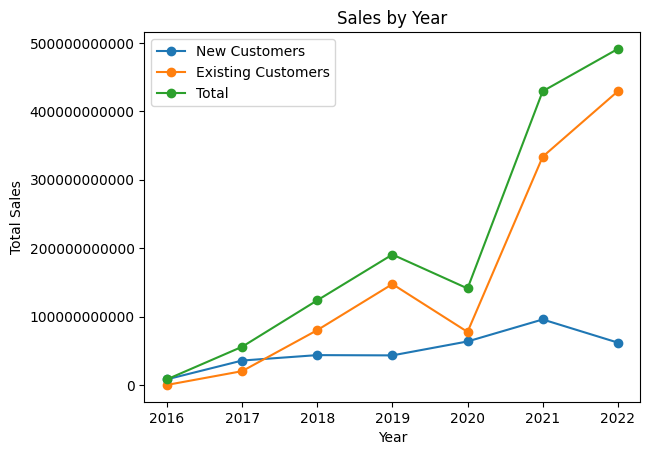

In [ ]:
# Plot the lines for 'New Customers', 'Existing Customers', and 'Total'
sales_by_year.plot(kind='line', marker='o')

plt.title('Sales by Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')

# Modify the y-axis tick labels to display in full numeric form
plt.ticklabel_format(style='plain', axis='y')

plt.show()

## sales proportion for new vs existing by year

In [ ]:
# number of customer_counts
customer_counts = .groupby('join_year')['customer_id'].nunique()

new_customers_count = customer_counts[customer_counts.index == 2016].sum()
existing_customers_count = customer_counts[customer_counts.index < 2016].sum()

In [ ]:
merged_new[merged_new.duplicated(subset='customer_id', keep=False)]['customer_id'].nunique()

41766

In [ ]:
customer_counts

join_year
2016     2478
2017     6541
2018     7414
2019     8106
2020     9205
2021    10681
2022     5817
Name: customer_id, dtype: int64

In [ ]:
2016     4729
2017    11440
2018    13587
2019    15303
2020    17821
2021    22760
2022    14360

In [ ]:
print(new_customers_count, existing_customers_count)

2478 0


In [ ]:
merged_new.customer_id

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

# number of customer_counts
customer_counts = merged_new.groupby('join_year')['customer_id'].nunique()

new_customers_count = customer_counts[customer_counts.index == 2016]
existing_customers_count = customer_counts[customer_counts.index < 2016].sum()

new_16_count = s_16_new / merged_new[merged_new['join_year'] == 2016]['customer_id'].nunique()
print(merged_new[merged_new['join_year'] == 2016]['customer_id'].nunique())
existing_16_count = 'NA'

new_17_count = s_17_new / merged_new[merged_new['join_year'] == 2017]['customer_id'].nunique()
existing_17_count = s_16_existing / merged_new[merged_new['join_year'] < 2017]['customer_id'].nunique()

new_18_count = s_18_new / merged_new[merged_new['join_year'] == 2018]['customer_id'].nunique()
existing_18_count = s_18_existing / merged_new[merged_new['join_year'] < 2018]['customer_id'].nunique()

new_19_count = s_19_new / merged_new[merged_new['join_year'] == 2019]['customer_id'].nunique()
existing_19_count = s_19_existing / merged_new[merged_new['join_year'] < 2019]['customer_id'].nunique()

new_20_count = s_20_new / merged_new[merged_new['join_year'] == 2020]['customer_id'].nunique()
existing_20_count = s_20_existing / merged_new[merged_new['join_year'] < 2020]['customer_id'].nunique()

new_21_count = s_21_new / merged_new[merged_new['join_year'] == 2021]['customer_id'].nunique()
existing_21_count = s_21_existing / merged_new[merged_new['join_year'] < 2021]['customer_id'].nunique()

new_22_count = s_22_new / merged_new[merged_new['join_year'] == 2022]['customer_id'].nunique()
existing_22_count = s_22_existing / merged_new[merged_new['join_year'] < 2022]['customer_id'].nunique()

# Create a dictionary to store the data
data = {
    'Year': [2016, 2017, 2018, 2019, 2020, 2021, 2022],
    'New Customers': [new_16_count, new_17_count, new_18_count, new_19_count, new_20_count, new_21_count, new_22_count],
    'Existing Customers': [existing_16_count, existing_17_count, existing_18_count, existing_19_count, existing_20_count, existing_21_count, existing_22_count]
}

# Create a DataFrame from the data
avg_by_year = pd.DataFrame(data)

# Set the 'Year' column as the index
avg_by_year.set_index('Year', inplace=True)
avg_by_year

2478


,New Customers,Existing Customers
Year,,
2016,3297985.35,NA
2017,5448354.35,0.00
2018,5877689.02,8880284.69
2019,5327639.96,8970437.44
2020,6904036.45,3158148.40
2021,8960717.88,9888411.31
2022,10632494.83,9665368.12


In [ ]:
display(merged_new.head(), merged_new.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1254585 entries, 0 to 1254584
Data columns (total 18 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   first_join_date  1254585 non-null  datetime64[ns]
 1   customer_id      1254585 non-null  int64         
 2   created_at       1254585 non-null  datetime64[ns]
 3   session_id       1254585 non-null  object        
 4   payment_method   1254585 non-null  object        
 5   payment_status   1254585 non-null  object        
 6   w_promo          1254585 non-null  int64         
 7   promo_amount     1254585 non-null  int64         
 8   promo_code       1254585 non-null  object        
 9   shipment_fee     1254585 non-null  int64         
 10  quantity         1254585 non-null  int64         
 11  item_price       1254585 non-null  int64         
 12  total_amount     1254585 non-null  int64         
 13  product_id       1254585 non-null  int64         
 14  us

,first_join_date,customer_id,created_at,session_id,payment_method,payment_status,w_promo,promo_amount,promo_code,shipment_fee,quantity,item_price,total_amount,product_id,username,gender,birthdate,device_type
0,2018-07-28,5868,2018-07-29,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1,1415,WEEKENDSERU,10000,1,191247,199832,54728,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,F,2000-08-20,Android
1,2018-07-28,4774,2018-07-30,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,0,0,10000,1,145526,155526,16193,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
2,2018-07-28,4774,2018-09-15,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,0,0,10000,4,135174,550696,53686,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
3,2018-07-28,4774,2018-11-01,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,0,0,0,1,271012,271012,20228,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
4,2018-07-28,4774,2018-12-18,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,0,0,0,1,198753,198753,55220,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android


None

## 고객 특성 및 패턴 파악: customer segmentation with promocode

"Heavy Promo Users," "Occasional Promo Users," and "Non-Promo Users"

In [17]:
merged_promo = merged[['customer_id', 'w_promo']]

# 고객별 프로모션 사용한 transaction 수
# the count of transactions with promotions for each customer)
promo_counts = merged_promo.groupby('customer_id')['w_promo'].sum().reset_index(name='promo_count')

# 고객별 전체 transaction 수
# the total count of transactions (both with promotions and non-promotions) for each customer
total_counts = merged_promo.groupby('customer_id')['w_promo'].count().reset_index(name='total_count')

# merge the two
merged_counts = promo_counts.merge(total_counts, on='customer_id', how='outer')

# ratio
merged_counts['promo_ratio'] = merged_counts['promo_count'] / merged_counts['total_count']

merged_counts.head()

,customer_id,promo_count,total_count,promo_ratio
0,3,37,69,0.536232
1,8,1,8,0.125000
2,9,0,8,0.000000
3,11,1,1,1.000000
4,15,4,9,0.444444


In [18]:
merged_counts.describe()

,customer_id,promo_count,total_count,promo_ratio
count,50242.000000,50242.000000,50242.000000,50242.000000
mean,49816.004259,9.175013,23.905000,0.359920
std,28946.354892,18.866227,42.640765,0.310760
min,3.000000,0.000000,1.000000,0.000000
25%,24706.500000,1.000000,2.000000,0.076923
50%,49742.500000,2.000000,8.000000,0.333333
75%,74844.250000,9.000000,26.000000,0.518519
max,99999.000000,504.000000,807.000000,1.000000


In [19]:
import pandas as pd

# Define the labels for each segmentation
labels = ['Non', 'Occasional1', 'Occasional2', 'Heavy']

# Define the cutoff values based on quartiles (25%, 50%, 75%, 100%)
cutoffs = [0, merged_counts['promo_ratio'].quantile(0.25), merged_counts['promo_ratio'].quantile(0.50), merged_counts['promo_ratio'].quantile(0.75), 1]

# Assign the labels to each segmentation based on the promo_ratio
merged_counts['segment'] = pd.cut(merged_counts['promo_ratio'], bins=cutoffs, labels=labels)

# Display the result
print(merged_counts)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



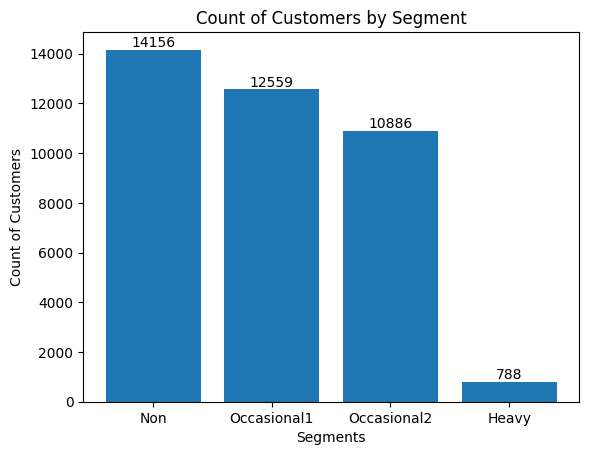

In [20]:
# Calculate the count of unique customers for each segment
customer_count = merged_counts['segment'].value_counts()

# Create a bar plot
plt.bar(range(1, 5), customer_count)
plt.xlabel('Segments')
plt.ylabel('Count of Customers')
plt.xticks(range(1, 5), labels)
plt.title('Count of Customers by Segment')

# Add count values on top of each bar
for i, count in enumerate(customer_count):
    plt.text(i + 1, count, str(count), ha='center', va='bottom')

# Display the plot
plt.show()


In [21]:
# average promo_ratio
merged_counts['promo_ratio'].sum()/merged_counts.shape[0]

0.35991994358029367

### Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


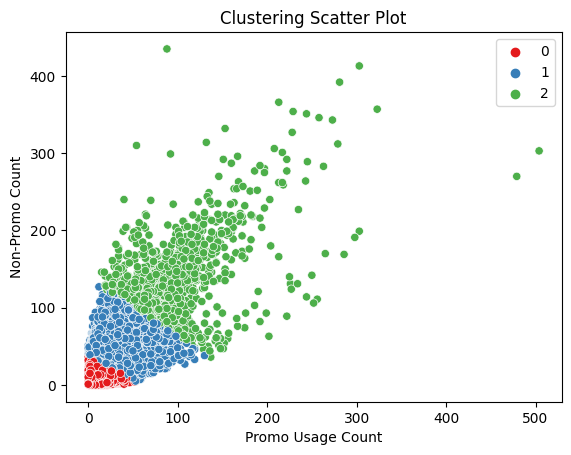

In [23]:
# non-promo count by subtracting the promo count from the total count
non_promo_count = merged_counts['total_count'] - merged_counts['promo_count']

# the data for clustering
data = pd.DataFrame({'promo_count': merged_counts['promo_count'], 'non_promo_count': non_promo_count})

# k-means clustering
kmeans = KMeans(3)
kmeans.fit(data)

# Assign cluster labels to each data point
cluster_labels = kmeans.labels_

# clustering scatter plot
sns.scatterplot(x=merged_counts['promo_count'], y=non_promo_count, hue=cluster_labels, palette='Set1')
plt.xlabel('Promo Usage Count')
plt.ylabel('Non-Promo Count')
plt.title('Clustering Scatter Plot')

# Display the plot
plt.show()

### promo_code Mapping

In [61]:
promo_code_mapping = {0: 0, 'AZ2022': 1, 'BUYMORE': 2, 'WEEKENDSERU': 3, 'XX2022': 4, 'LIBURDONG': 5, 'WEEKENDMANTAP': 6, 'SC2022': 7, 'STARTUP': 8}

# Apply the mapping to the promo_code column
merged_new['promo_code'] = merged_new['promo_code'].map(promo_code_mapping)

<ipython-input-61-f9534a8dc240>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_new['promo_code'] = merged_new['promo_code'].map(promo_code_mapping)


In [ ]:
len(merged_new[merged_new['first_join_date'].dt.date == merged_new['created_at'].dt.date])

35291

### promocode를 사용한 구매자와 사용하지 않은 구매자들의 요일 별 구매 수

In [42]:
merged_pattern = merged[['first_join_date', 'customer_id', 'created_at', 'w_promo','promo_amount',
                         'shipment_fee', 'item_price', 'total_amount', 'product_id', 'gender',
                         'birthdate', 'device_type', 'birthdate']]
merged_pattern.head(5)

,first_join_date,customer_id,created_at,w_promo,promo_amount,shipment_fee,item_price,total_amount,product_id,gender,birthdate,device_type,birthdate
0,2018-07-28,5868,2018-07-29,1,1415,10000,191247,199832,54728,F,2000-08-20,Android,2000-08-20
1,2018-07-28,4774,2018-07-30,0,0,10000,145526,155526,16193,F,1996-03-15,Android,1996-03-15
2,2018-07-28,4774,2018-09-15,0,0,10000,135174,550696,53686,F,1996-03-15,Android,1996-03-15
3,2018-07-28,4774,2018-11-01,0,0,0,271012,271012,20228,F,1996-03-15,Android,1996-03-15
4,2018-07-28,4774,2018-12-18,0,0,0,198753,198753,55220,F,1996-03-15,Android,1996-03-15


In [40]:
merged_pattern['day_of_week'] = merged_pattern['created_at'].dt.day_name()
promo_counts = merged_pattern.groupby(['day_of_week', 'w_promo']).size().unstack(fill_value=0)

<ipython-input-40-50589422a317>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_pattern['day_of_week'] = merged_pattern['created_at'].dt.day_name()


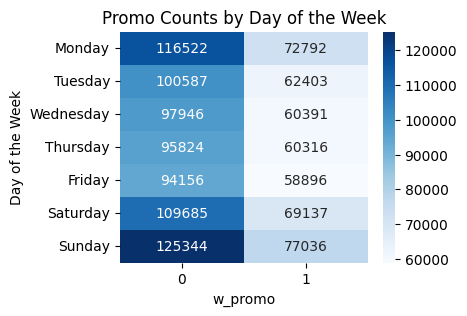

In [41]:
# Define the desired order of the days of the week
desired_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex the promo_counts DataFrame with the desired order
promo_counts = promo_counts.reindex(desired_order)

# Create the heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(promo_counts, cmap='Blues', annot=True, fmt='d')
plt.title('Promo Counts by Day of the Week')
plt.xlabel('w_promo')
plt.ylabel('Day of the Week')
plt.show()

sat, sun, mon 제일 많음

### promo_code users (age에 따른)

In [47]:
merged_pattern.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201035 entries, 0 to 1201034
Data columns (total 13 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   first_join_date  1201035 non-null  datetime64[ns]
 1   customer_id      1201035 non-null  int64         
 2   created_at       1201035 non-null  datetime64[ns]
 3   w_promo          1201035 non-null  int64         
 4   promo_amount     1201035 non-null  int64         
 5   shipment_fee     1201035 non-null  int64         
 6   item_price       1201035 non-null  int64         
 7   total_amount     1201035 non-null  int64         
 8   product_id       1201035 non-null  int64         
 9   gender           1201035 non-null  object        
 10  birthdate        1201035 non-null  datetime64[ns]
 11  device_type      1201035 non-null  object        
 12  birthdate        1201035 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(7), object(2)
memory usage: 1

In [49]:
import datetime

current_date = datetime.date(2022, 8, 1).todate

# the age by subtracting birthdate from current date and extracting the years
merged_pattern['age'] = (current_date - merged_pattern['birthdate']).dt.days // 365

# Display the dataframe with the age column
print(merged_pattern)

TypeError: ignored

<ipython-input-27-a07e1cebaabb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_pattern.corr()


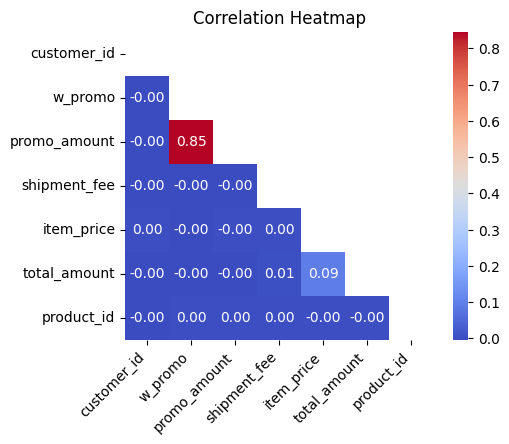

In [27]:
# Create a correlation matrix from the dataframe
corr_matrix = merged_pattern.corr()

# Generate a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(5, 4))

# Create the heatmap with the masked upper triangle
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", square=True, ax=ax)

# Set the title of the heatmap
ax.set_title('Correlation Heatmap')

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the heatmap
plt.show()

## relationship bet promo usage and new customer influx

In [ ]:
len(merged_new[merged_new['w_promo'] == 1])

481139

In [ ]:
promo_date = merged_new.groupby('promo_code')['created_at'].agg(['min', 'max'])

# the date range for each promo_code
print(promo_date)

                  min        max
promo_code                      
0          2016-06-30 2022-07-31
1          2016-07-04 2022-07-29
2          2016-07-04 2022-07-29
3          2016-07-02 2022-07-31
4          2016-07-01 2022-07-29
5          2016-07-09 2022-07-31
6          2016-07-03 2022-07-31
7          2016-07-04 2022-07-29
8          2016-07-12 2022-07-29


In [ ]:
promo_month = merged_new[merged_new['payment_status'] == 'Success'].groupby('promo_code')['created_at'].apply(lambda x: x.dt.month.unique())

# Print the unique months for each promo_code
print(promo_month)

promo_code
0    [7, 9, 11, 12, 3, 5, 2, 8, 10, 1, 4, 6]
1    [6, 4, 7, 12, 3, 10, 2, 9, 1, 5, 11, 8]
2    [2, 8, 11, 1, 7, 10, 3, 6, 12, 9, 4, 5]
3    [7, 8, 10, 9, 1, 11, 2, 3, 5, 6, 12, 4]
4    [6, 12, 1, 8, 9, 4, 5, 3, 10, 11, 7, 2]
5    [12, 4, 11, 5, 2, 9, 8, 7, 1, 6, 10, 3]
6    [2, 7, 4, 1, 3, 6, 9, 10, 8, 11, 12, 5]
7    [12, 1, 7, 6, 11, 2, 4, 10, 8, 3, 9, 5]
8    [4, 7, 3, 1, 6, 8, 12, 2, 9, 11, 10, 5]
Name: created_at, dtype: object




> promocode 이름에 의미없음 -> 연도, 월 상관없이 사용됐기 때문.



## customer influx by promo

In [ ]:
# total: 1254585 rows
# first_join_date와 created_at 의 날짜가 동일한 row 수 추출
matching_dates_promo = merged_new[(merged_new['first_join_date'].dt.date == merged_new['created_at'].dt.date) & (merged_new['w_promo'] == 1)]
count_matching = len(matching_dates_promo)
count_matching / merged_new.shape[0]

0.009974613119079217

In [49]:
# first created_at(merged_new.shape[0] proportion
# 가입날 == 결제일, first_transaction에서 promo가 사용된 결제의 비율
first_transaction = merged_new.groupby('customer_id')['created_at'].min()
completed_promo_transactions = merged_new[merged_new['w_promo'] == 1]
customers_completed_promo = first_transaction[first_transaction.isin(completed_promo_transactions['created_at'])]
proportion = len(customers_completed_promo) / merged_new.shape[0]
proportion

0.04183142039990508

Only 4% 만이 promo_code 로 인해 가입했다 말할수 있음!

In [40]:
merged_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201035 entries, 0 to 1201034
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   first_join_date  1201035 non-null  object        
 1   customer_id      1201035 non-null  int64         
 2   created_at       1201035 non-null  datetime64[ns]
 3   w_promo          1201035 non-null  int64         
 4   promo_amount     1201035 non-null  int64         
 5   promo_code       460971 non-null   object        
 6   product_id       1201035 non-null  int64         
 7   gender           1201035 non-null  object        
 8   birthdate        1201035 non-null  object        
 9   device_type      1201035 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 100.8+ MB


In [52]:
time_diff

customer_id
3       0 days
8       0 days
9       1 days
11      1 days
15      2 days
         ...  
99992   0 days
99995   3 days
99997   0 days
99998   1 days
99999   0 days
Length: 50242, dtype: timedelta64[ns]

In [51]:
# 첫구매를 가입 후 1주일 안에 했으며, promo_code를 입력한 경우 (customer_id별 첫 결제일 == 가입날 포함 1주일, w_promo == 1)
# first_transaction isin 7 days including 
# time difference between first transaction and first join date
time_diff = merged_new.groupby('customer_id')['created_at'].min() - merged_new.groupby('customer_id')['first_join_date'].min()

# the number of customers with time difference <= 7 days
count_within_7_days = (time_diff <= pd.Timedelta(days=7)).sum()

total_customers = merged_new['customer_id'].nunique()

print("Ratio of customers with first transaction within 7 days:", count_within_7_days / total_customers)

Ratio of customers with first transaction within 7 days: 0.9596950758329684


In [ ]:
# first_join_date와 created_at 의 날짜가 동일하고 w_promo가 1인 row 수 추출
matching = merged_new[merged_new['first_join_date'].dt.date == merged_new['created_at'].dt.date]
matching_promo = matching[matching['w_promo'] == 1]
new_customers_promo = len(matching_promo) / len(matching)
new_customers_promo

0.35459465586126776

In [ ]:
199832 - 191247	- 10000 - 1415

-2830

In [ ]:
promo_by_customer

In [ ]:
863863-(98088+443219+134257)-(11701*3)

153196

In [ ]:
268925-4146

264779

In [ ]:
transaction['discount'] = transaction['total_amount'] // transaction['promo_amount']

In [ ]:
test_ttl['item_price'].sum() + shipment_fee - promo_amount

1294812

In [ ]:
1294812 + 10000 - 9072

1295740

In [ ]:
test_ttl = merged_new[(merged_new['customer_id'] == 4774) & (merged_new['created_at'] == '2019-08-10')]
test_ttl
test_ttl['item_price'] - test_ttl['promo_amount'] + test_ttl['shipment_fee']

,first_join_date,customer_id,created_at,payment_method,payment_status,promo_amount,promo_code,shipment_fee,quantity,item_price,total_amount,product_id,username,gender,birthdate,device_type
9,2018-07-28,4774,2019-08-10,Credit Card,Success,9072,3,10000,1,292052,1295740,53051,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
10,2018-07-28,4774,2019-08-10,Credit Card,Success,9072,3,10000,1,241945,1295740,46352,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
11,2018-07-28,4774,2019-08-10,Credit Card,Success,9072,3,10000,1,297248,1295740,6352,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
12,2018-07-28,4774,2019-08-10,Credit Card,Success,9072,3,10000,1,191138,1295740,26620,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
13,2018-07-28,4774,2019-08-10,Credit Card,Success,9072,3,10000,1,78559,1295740,22849,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
14,2018-07-28,4774,2019-08-10,Credit Card,Success,9072,3,10000,1,193870,1295740,56247,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android


In [ ]:
total_price = test_ttl['item_price'].sum()
print(total_price)
9072*
ttl_aft_promo = total_price - test_ttl['promo_amount'].sum()
ttl_aft_promo

1294812


1240380

In [ ]:
promo_rate = merged_new[(merged_new['payment_status'] == 'Success') & (merged_new['promo_code'] != 0)]

promo_rate

,first_join_date,customer_id,created_at,payment_method,payment_status,promo_amount,promo_code,shipment_fee,quantity,item_price,total_amount,product_id,username,gender,birthdate,device_type
0,2018-07-28,5868,2018-07-29,Debit Card,Success,1415,3,10000,1,191247,199832,54728,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,F,2000-08-20,Android
5,2018-07-28,4774,2019-02-03,Debit Card,Success,6369,6,5000,1,183234,181865,59620,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
8,2018-07-28,4774,2019-06-24,Credit Card,Success,4019,1,10000,1,364776,370757,12282,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
9,2018-07-28,4774,2019-08-10,Credit Card,Success,9072,3,10000,1,292052,1295740,53051,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
10,2018-07-28,4774,2019-08-10,Credit Card,Success,9072,3,10000,1,241945,1295740,46352,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254575,2022-05-06,99675,2022-07-07,Credit Card,Success,3388,4,0,1,488722,485334,35318,b12282d0-f890-41b3-977e-43a7f89b95c1,F,1991-08-17,iOS
1254581,2021-12-08,34829,2021-12-09,OVO,Success,5010,1,10000,1,354213,359203,19394,46d47eaa-4d8a-4f17-b083-48c2ad4fe947,F,2006-04-21,Android
1254582,2021-12-08,99645,2021-12-11,Credit Card,Success,2181,3,5000,4,288835,1158159,13079,f09d115a-a950-451e-9c4f-de117a2657f4,F,1991-03-17,Android
1254583,2019-12-18,87319,2019-12-18,Credit Card,Success,4503,1,0,1,188646,184143,11312,57561022-e2f9-42de-a46b-428cce52e5dc,F,2007-10-26,iOS


In [ ]:
# check the num of new join during promo period


0          3
5          6
8          1
9          3
10         3
          ..
1254575    4
1254581    1
1254582    3
1254583    1
1254584    2
Name: promo_code, Length: 481139, dtype: int64

In [ ]:
# Convert 'created_at' and 'first_join_date' to datetime
merged['created_at'] = pd.to_datetime(merged['created_at'])
merged['first_join_date'] = pd.to_datetime(merged['first_join_date'])

# Calculate tenure in days
merged['tenure'] = (merged['created_at'] - merged['first_join_date']).dt.days

In [ ]:
transaction_re = transaction.to_csv('preprocessed_transaction.csv', index=False)

In [ ]:
merged['tenure'].value_counts()
# 2022

NameError: ignored

In [ ]:
# Calculate the proportion of transactions with promotions
total_transactions = len(transaction)
promotions_count = transaction['promo_code'].notnull().sum()
promotions_proportion = promotions_count / total_transactions

# Calculate the proportion of transactions without promotions
no_promotions_count = total_transactions - promotions_count
no_promotions_proportion = no_promotions_count / total_transactions

print("Proportion of transactions with promotions:", promotions_proportion.round(2))
print("Proportion of transactions without promotions:", no_promotions_proportion.round(2))

Proportion of transactions with promotions: 0.38
Proportion of transactions without promotions: 0.62


In [ ]:
# Identify customers who have churned (not made any recent transactions)
churned_customers = customer[~customer['customer_id'].isin(transaction['customer_id'])]

# Analyze their promotional behavior
churned_promotions_count = churned_customers['promo_code'].notnull().sum()
churned_no_promotions_count = len(churned_customers) - churned_promotions_count

print("Churned customers using promotions:", churned_promotions_count)
print("Churned customers not using promotions:", churned_no_promotions_count)

KeyError: ignored